In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


**Loading the dataset**

In [2]:
customer_df=pd.read_csv('./dataset/olist_customers_dataset.csv')
geolocation_df=pd.read_csv('./dataset/olist_geolocation_dataset.csv')
order_items_df=pd.read_csv('./dataset/olist_order_items_dataset.csv')
orders_payments_df=pd.read_csv('./dataset/olist_order_payments_dataset.csv')
orders_reviews_df=pd.read_csv('./dataset/olist_order_reviews_dataset.csv')
olist_orders_df=pd.read_csv('./dataset/olist_orders_dataset.csv')
olist_product_df=pd.read_csv('./dataset/olist_products_dataset.csv')
olist_sellers_df=pd.read_csv('./dataset/olist_sellers_dataset.csv')
product_category_df=pd.read_csv('./dataset/product_category_name_translation.csv')


### Joining the Tables Together

The data is stored in multiple tables, such as the orders table, products table, reviews table, etc. This structure enhances human readability and reduces potential duplicated data. However, this format does not allow us to analyze data across multiple tables simultaneously. Therefore, it is more convenient to join these tables together before proceeding with our analysis.

We will join the tables according to the data schema shown below:
- `customer_df` contains customer information.
- `geolocation_df` contains geolocation information.
- `olist_orders_df` contains order information.
- `olist_product_df` contains product information.
- `olist_sellers_df` contains seller information.
- `order_items_df` contains order item details.
- `orders_payments_df` contains payment information.
- `orders_reviews_df` contains review information.
- `product_category_df` contains product category translations.

By joining these tables, we can create a comprehensive dataset that includes all relevant information for our analysis.

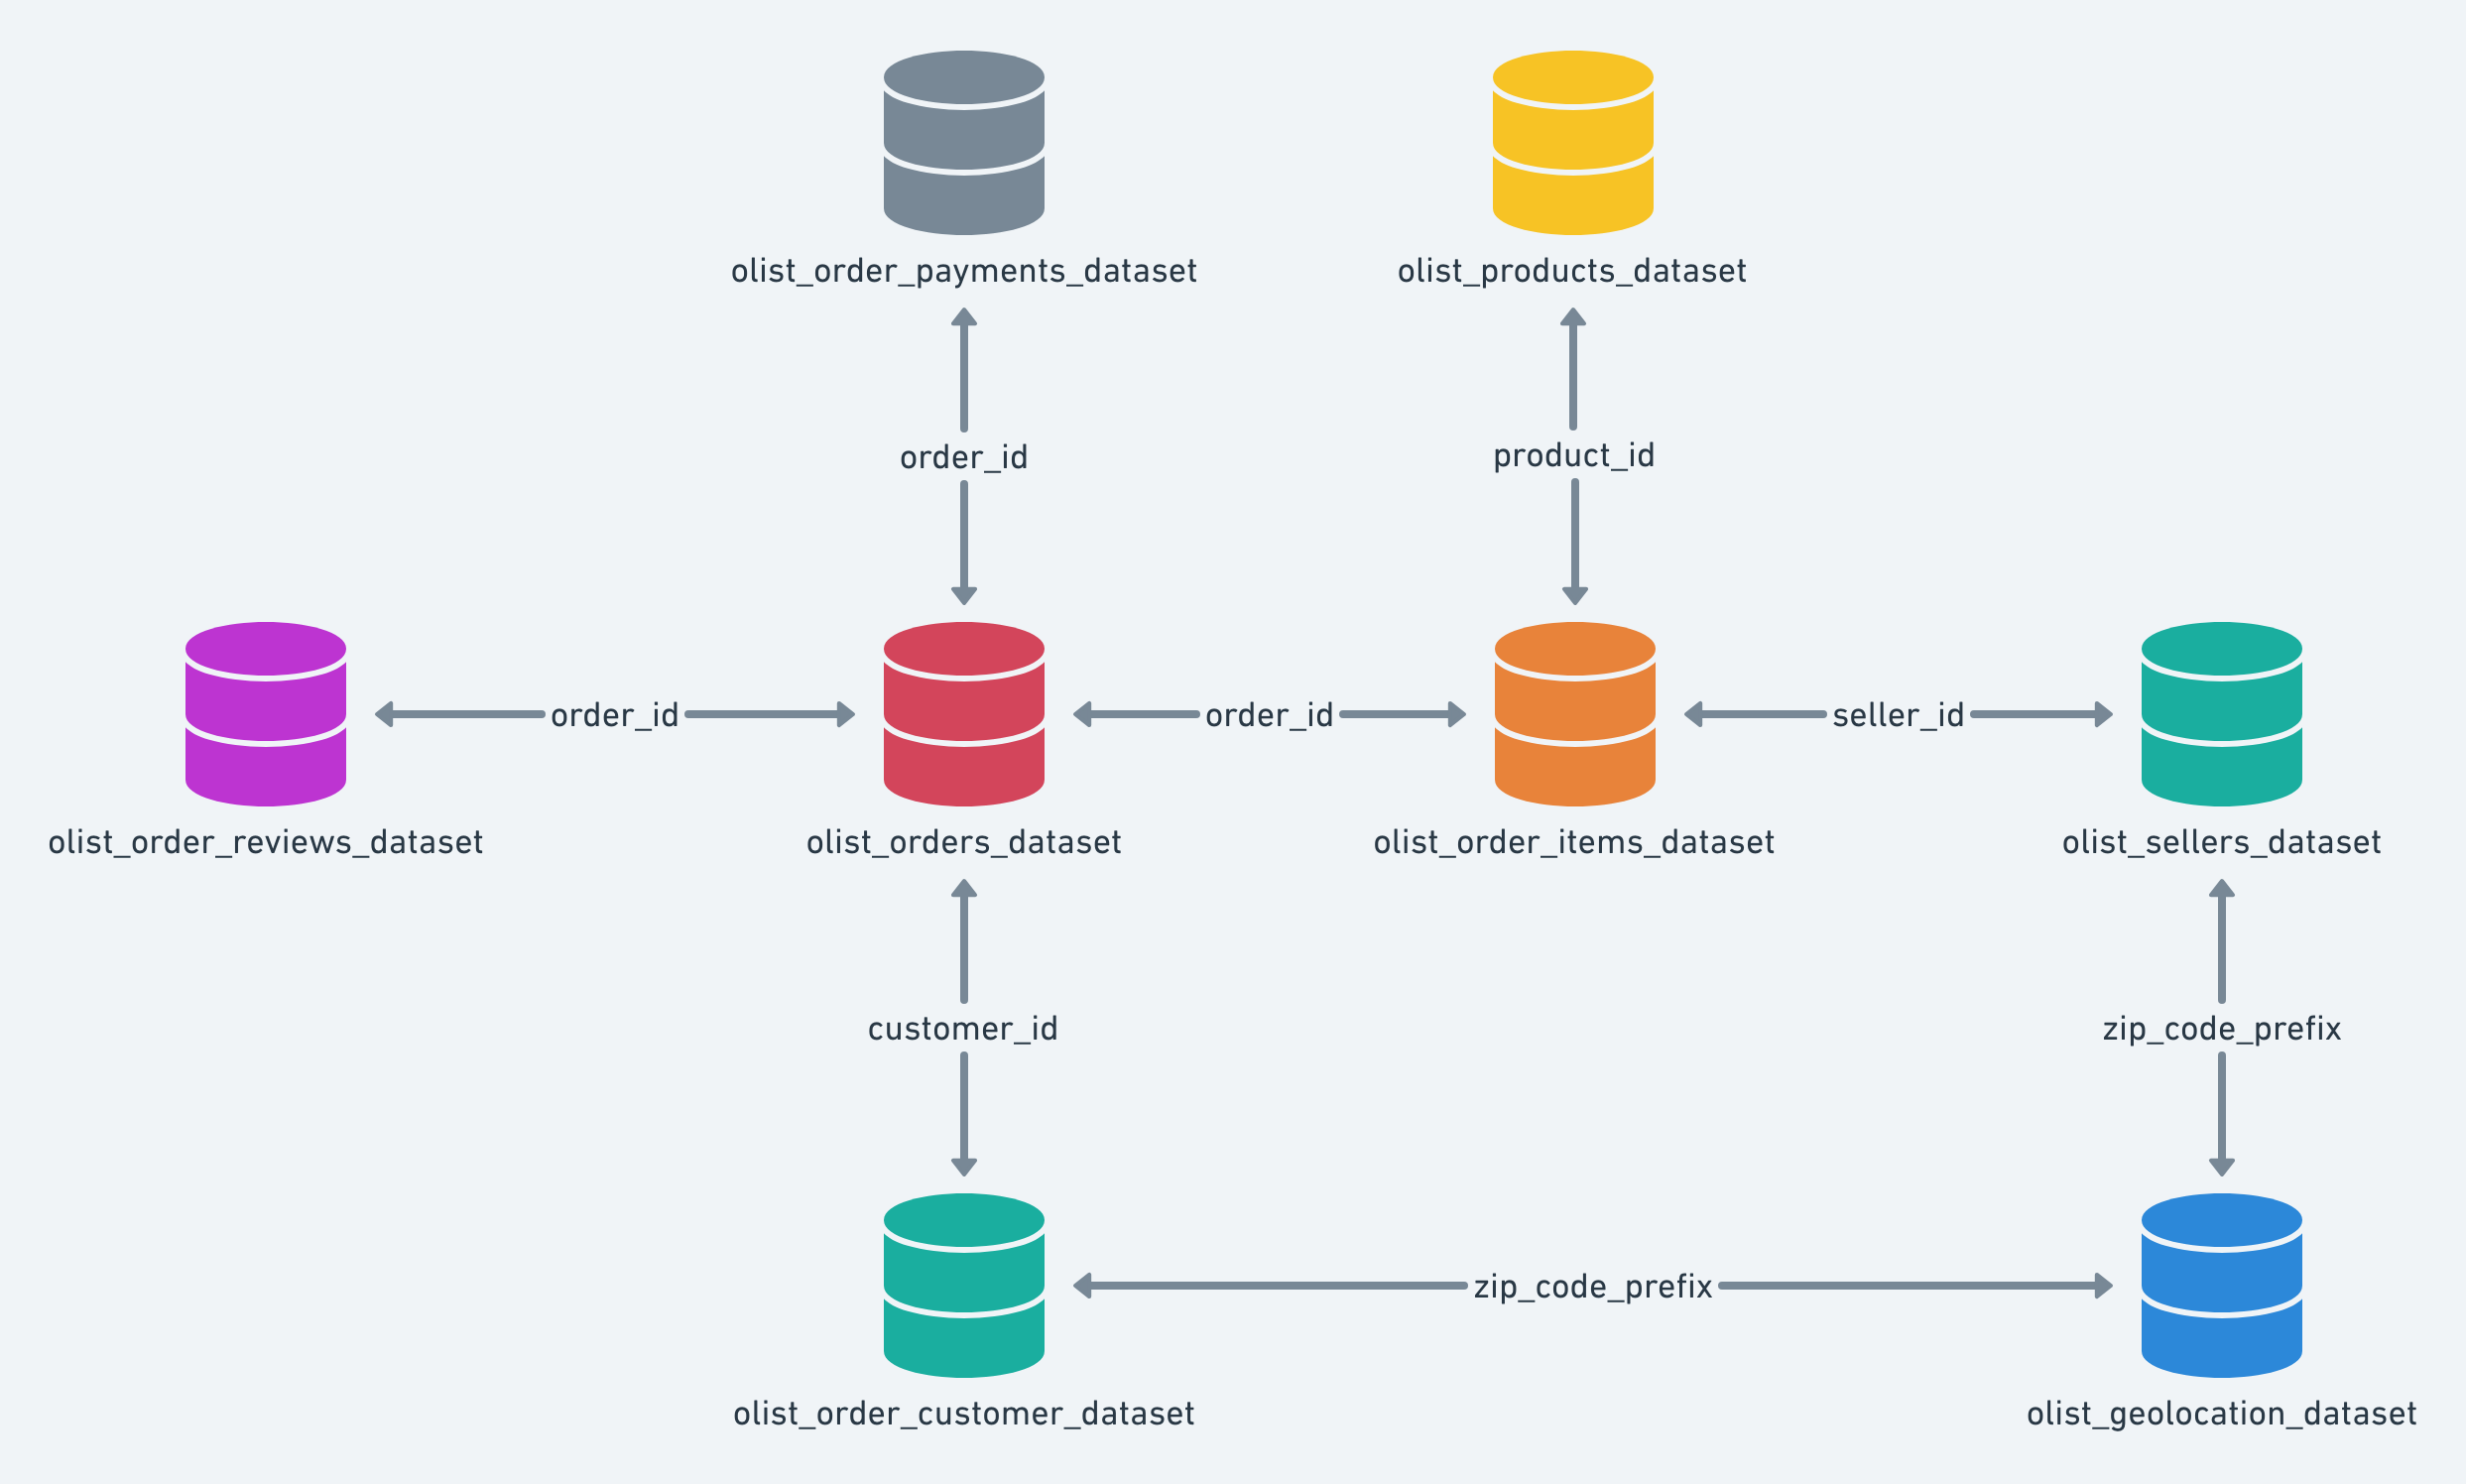
source:kaggle

In [8]:
# Merging datasets
dataset = olist_orders_df.merge(orders_reviews_df, on='order_id')\
    .merge(orders_payments_df, on='order_id')\
    .merge(customer_df, on='customer_id')\
    .merge(order_items_df, on='order_id')\
    .merge(olist_product_df, on='product_id')\
    .merge(olist_sellers_df, on='seller_id')

# Drop duplicates
dataset = dataset.drop_duplicates()

# Print the resulting dataset


### Reasons for Using Inner Join:

1️⃣ **To Ensure Data Completeness**
- Inner join only keeps matching records from both tables.
- If an order exists in `orders_df` but does not have a corresponding entry in `order_reviews_df`, it will be excluded.
- This ensures that all data in `full_df` is relevant and complete.

2️⃣ **To Remove Incomplete or Orphan Records**
- Suppose we used a left join (keeping all records from `orders_df`):
    - We might have orders without reviews or orders without payments.
    - These incomplete records could create inconsistencies in our analysis.
- **Example Issue:**
    - If an order does not have a payment record, it might be an incomplete transaction. Keeping it in the dataset could lead to incorrect financial analysis.

3️⃣ **To Reduce Data Size and Avoid Redundant Information**
- Keeping only the relevant data helps optimize memory usage and processing speed.
- **Example:**
    - If we used an outer join, we would include orders that don’t have reviews, payments, or product details. This would increase dataset size without adding much value.

4️⃣ **To Maintain Data Integrity for Analysis**
- If we included rows without corresponding data, certain operations (e.g., computing revenue, customer satisfaction, or product sales) could be misleading due to missing values.


### DataFrame Summary

We use the `df_summary` function to inspect our data at a high level. It is more informative and readable than the `DataFrame.info()` function provided by Pandas. We will also use this to check our data after preprocessing.

In [13]:
from scipy import stats


def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column', 'dtypes']]
    
    summary['#Missing'] = df.isnull().sum().values
    summary['#Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values
    
    # Calculate entropy for each column
    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)
    
    
     # Create a separate DataFrame for numerical statistics
    numerical_cols = df.select_dtypes(include=['number']).columns
    numerical_summary = pd.DataFrame(index=numerical_cols)
    numerical_summary['Mean'] = df[numerical_cols].mean()
    numerical_summary['Median'] = df[numerical_cols].median()
    numerical_summary['StdDev'] = df[numerical_cols].std()
    numerical_summary['Min'] = df[numerical_cols].min()
    numerical_summary['Max'] = df[numerical_cols].max()
    
    # Merge numerical statistics with the summary DataFrame
    summary = summary.merge(numerical_summary, left_on='Column', right_index=True, how='left')
    
   
    
    
    return summary
df_summary(dataset)

# Example usage
# summary = df_summary(dataset)
# print(summary)

Dataset Shape: (117329, 39)


,Column,dtypes,#Missing,#Unique,Example,Entropy,Mean,Median,StdDev,Min,Max
0,order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43,NaN,NaN,NaN,NaN,NaN
1,customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43,NaN,NaN,NaN,NaN,NaN
2,order_status,object,0,7,delivered,0.19,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,object,0,97370,2017-10-02 10:56:33,16.42,NaN,NaN,NaN,NaN,NaN
4,order_approved_at,object,15,89533,2017-10-02 11:07:15,16.26,NaN,NaN,NaN,NaN,NaN
5,order_delivered_carrier_date,object,1235,80449,2017-10-04 19:55:00,16.02,NaN,NaN,NaN,NaN,NaN
6,order_delivered_customer_date,object,2471,95021,2017-10-10 21:25:13,16.39,NaN,NaN,NaN,NaN,NaN
7,order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,8.47,NaN,NaN,NaN,NaN,NaN
8,review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43,NaN,NaN,NaN,NaN,NaN
9,review_score,int64,0,5,4,1.77,4.031467,5.00,1.387927,1.00,5.00


### Why is Entropy Significant?

#### Data Diversity and Uncertainty:

- **High Entropy:**
    - Indicates that the values are more uniformly distributed; no single value dominates.
    - Suggests high diversity in the data.

- **Low Entropy:**
    - Indicates that one or a few values are predominant.
    - Could mean that the column has low variability, which might be important for data cleaning or feature selection.

#### Feature Selection for Modeling:

- Columns with extremely low entropy may not be very informative for predictive models because they don't provide much variance.
- Conversely, columns with high entropy contain more information and variability that could be useful in modeling.

#### Data Quality Insights:

- Calculating entropy as part of a summary can help identify columns that might require further cleaning or transformation.
- For instance, if a column supposed to be diverse shows very low entropy, it might indicate data entry errors or other issues.

#### Comparative Analysis:

- When comparing multiple columns, entropy provides a quantitative measure to assess which columns are more varied versus those that are nearly constant.
- This can help prioritize which columns to focus on during exploratory data analysis (EDA).

**Datetime conversion**

In [18]:
datetime_columns = ['order_purchase_timestamp', 'order_approved_at', 
                    'order_delivered_carrier_date', 'order_delivered_customer_date', 
                    'order_estimated_delivery_date', 
                    'review_creation_date', 'review_answer_timestamp',
                    'shipping_limit_date']
dataset[datetime_columns] = dataset[datetime_columns].apply(pd.to_datetime)

### Benefits of Datetime Conversion

1. **Accurate Date Calculations**
    - **Date Arithmetic:** Converting columns to datetime format allows you to perform accurate date arithmetic, such as calculating the difference between two dates, adding or subtracting days, and more.
    - **Time Intervals:** You can easily calculate time intervals, such as the number of days, months, or years between two dates.

2. **Time Series Analysis**
    - **Resampling:** Datetime conversion enables resampling of time series data, such as aggregating data by day, week, month, or year.
    - **Rolling Windows:** You can apply rolling window calculations, such as moving averages, which are essential for time series analysis.

3. **Data Filtering and Subsetting**
    - **Date Filtering:** You can filter and subset data based on specific date ranges, such as selecting data from the last month or the last year.
    - **Date Indexing:** Datetime conversion allows you to set date columns as the index, making it easier to work with time series data.

4. **Visualization**
    - **Time Series Plots:** Converting to datetime format enables the creation of time series plots, which are essential for visualizing trends and patterns over time.
    - **Seasonal Analysis:** You can visualize seasonal patterns and trends by grouping data by month, quarter, or year.

5. **Handling Missing Dates**
    - **Missing Dates:** Datetime conversion helps in identifying and handling missing dates in the dataset, ensuring the completeness of time series data.

In [15]:
#fixing improper column names
dataset = dataset.rename(columns={'product_name_lenght': 'product_name_length',
                                   'product_description_lenght': 'product_description_length'
                                  })

After preprocessing lets check the data again

In [16]:
#fixing improper column names
df_summary(dataset)

Dataset Shape: (117329, 39)


,Column,dtypes,#Missing,#Unique,Example,Entropy,Mean,Median,StdDev,Min,Max
0,order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43,NaN,NaN,NaN,NaN,NaN
1,customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43,NaN,NaN,NaN,NaN,NaN
2,order_status,object,0,7,delivered,0.19,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,datetime64[ns],0,97370,2017-10-02 10:56:33,16.42,NaN,NaN,NaN,NaN,NaN
4,order_approved_at,datetime64[ns],15,89533,2017-10-02 11:07:15,16.26,NaN,NaN,NaN,NaN,NaN
5,order_delivered_carrier_date,datetime64[ns],1235,80449,2017-10-04 19:55:00,16.02,NaN,NaN,NaN,NaN,NaN
6,order_delivered_customer_date,datetime64[ns],2471,95021,2017-10-10 21:25:13,16.39,NaN,NaN,NaN,NaN,NaN
7,order_estimated_delivery_date,datetime64[ns],0,449,2017-10-18 00:00:00,8.47,NaN,NaN,NaN,NaN,NaN
8,review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43,NaN,NaN,NaN,NaN,NaN
9,review_score,int64,0,5,4,1.77,4.031467,5.00,1.387927,1.00,5.00


# **Exploratory Data Analysis (EDA)**

EDA is a crucial step before building models. It helps us understand the dataset's characteristics and identify any anomalies or peculiarities that may affect modeling. EDA also allows us to observe data distribution and identify potential trends or patterns useful for model building. By performing EDA, we gain valuable insights and clues that guide us in constructing our models.

## Correlations

First of all, we find correlations in our dataset. This step is important because it can help us identify relationships between different variables. Correlated variables can help us reason about potential causes and effects.

The data contains columns of different types. For correlation analysis, we focus on the numeric columns. So, we need to first filter out the numeric columns.


In [28]:
numeric_columns=dataset.select_dtypes(include=['number']).columns
numeric_columns
#We will exclude zip_code, order_item, and seller_zip_code as they are not relevant to correlation analysis.
#these are the categorical columns or identifiers that do not have any numerical meaning .
exclude_columns=['customer_zip_code_prefix','order_item_id','seller_zip_code_prefix']
numeric_modified=numeric_columns.drop(exclude_columns)
dataset[exclude_columns].astype('str')#converting to string
numeric_df=dataset[numeric_modified]
corr=numeric_df.corr()







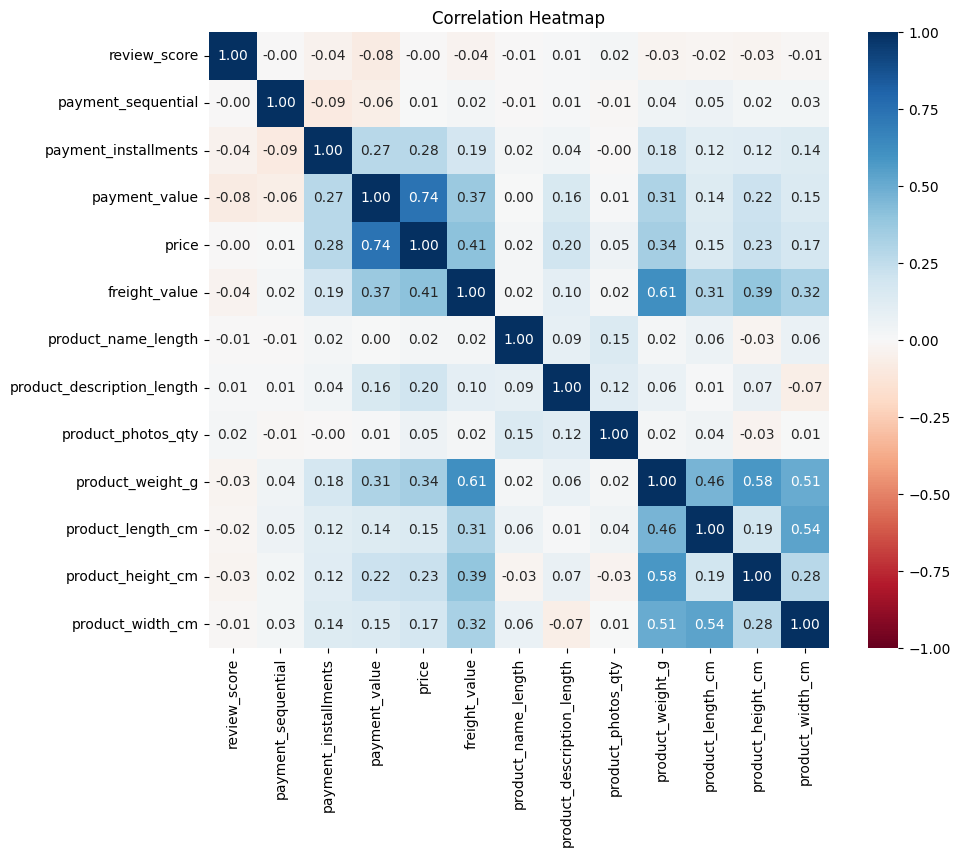

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

Red represents negative correlations (close to -1).
Blue represents positive correlations (close to +1).
White/neutral colors indicate weak or no correlation (close to 0).


**Correlation Analysis of Payment Value**
I have used thresholds of 0.3 and -0.3 to filter out the features that are most correlated with the payment value. The threshold of 0.3 and -0.3 is chosen because it indicates a moderate correlation, which is strong enough to be meaningful but not too high to suggest redundancy. As shown below, the price, freight value (transportation and delivery cost), and product weight are most correlated with the payment value. This result aligns with my expectations: the price and delivery cost are clearly main components of the payment; the weight of the product is a main determinant of the transportation cost. Therefore, the change in these features could largely affect the payment value.

In [30]:
corr_payment_value = corr.loc[(corr['payment_value'] > 0.3) | (corr['payment_value'] <= -0.3)]
corr_payment_value

,review_score,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
payment_value,-0.082404,-0.064475,0.274334,1.000000,0.741433,0.374270,0.003298,0.156257,0.009833,0.305458,0.139966,0.216773,0.148374
price,-0.004515,0.006717,0.279000,0.741433,1.000000,0.414014,0.017853,0.201950,0.052378,0.340712,0.145386,0.225115,0.172667
freight_value,-0.037076,0.021956,0.185774,0.374270,0.414014,1.000000,0.022442,0.096853,0.021786,0.611302,0.309137,0.394332,0.324993
product_weight_g,-0.028641,0.044021,0.177936,0.305458,0.340712,0.611302,0.021031,0.064236,0.021121,1.000000,0.462499,0.582490,0.506340


I use the `price`, `freight_value`, and `product_weight_g` columns to create pairplots and visualize their relationship with the payment value. Since the dataset is too large to fit onto a single plot, I decide to randomly take 500 samples from the dataset. This approach ensures a reasonable runtime for plotting while still allowing me to visualize the general trends and relationships of the features.

For better quality of the visualization and more readability, I remove outliers in the columns. This makes the plots more zoomed in on the regions where the data points are more densely clustered together. Additionally, I convert the unit of product weight from grams to kilograms so that the ticks become smaller and easier to understand.u


In [37]:
dataset_sample = dataset.sample(500, random_state=42)

# Convent product weight's unit from grams to kilograms
dataset_sample['product_weight_g'] = dataset_sample['product_weight_g'].apply(lambda x: x/1000)
dataset_sample = dataset_sample.rename(columns={'product_weight_g': 'product_weight_kg'})

# Remove outliers in payment_value
payment_value_q99 = dataset_sample['payment_value'].quantile(0.99)
dataset_sample = dataset_sample[dataset_sample['payment_value'] < payment_value_q99]

# Remove outliers in freight_value
freight_value_q99 = dataset_sample['freight_value'].quantile(0.99)
dataset_sample = dataset_sample[dataset_sample['freight_value'] < freight_value_q99]

# Remove outliers in product_weight
product_weight_q95 = dataset_sample['product_weight_kg'].quantile(0.95)
dataset_sample = dataset_sample[dataset_sample['product_weight_kg'] < product_weight_q95]

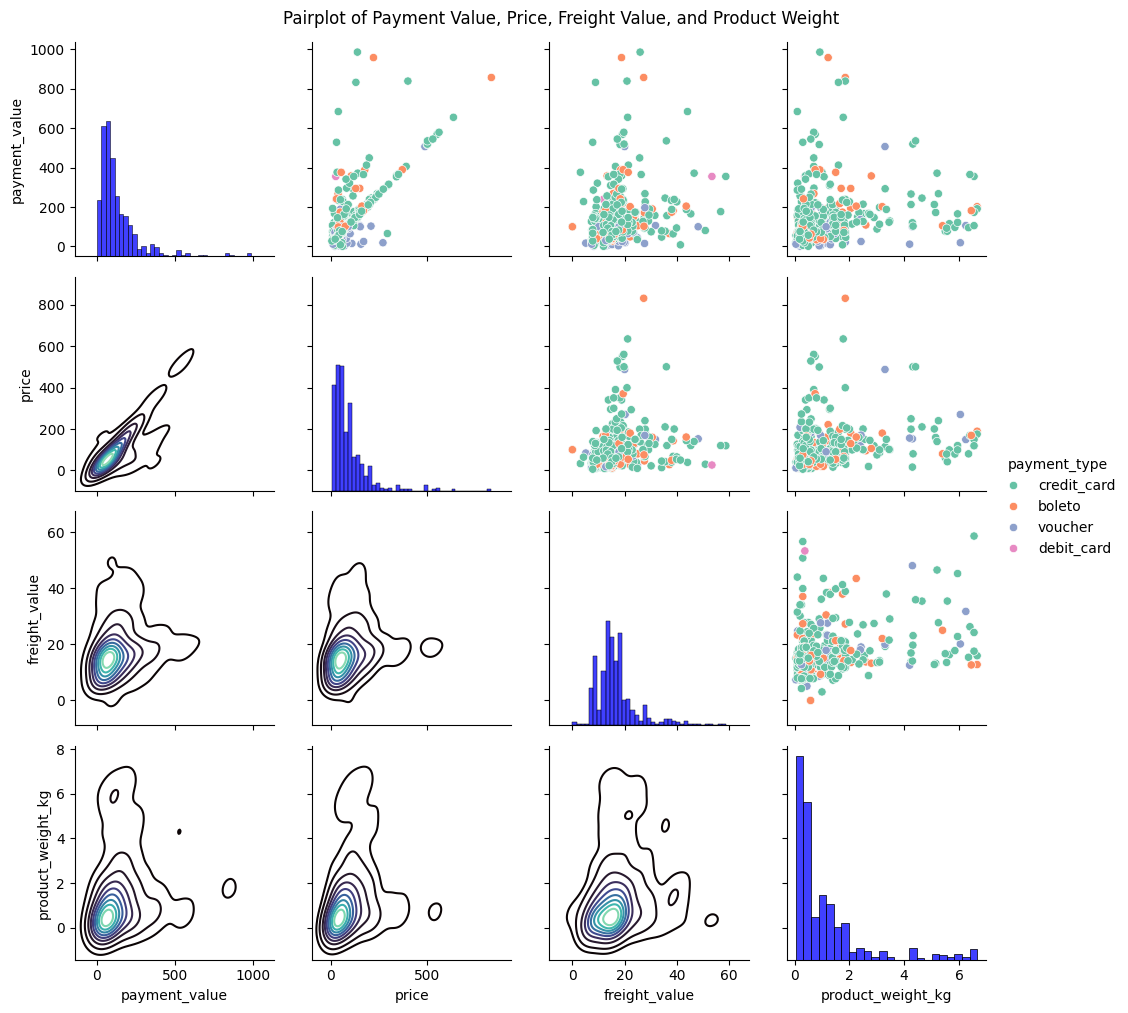

In [40]:
# Pairplot
g = sns.PairGrid(dataset_sample, hue='payment_type',
                 vars=['payment_value', 'price', 'freight_value', 'product_weight_kg'],
                 palette='Set2')
g.map_upper(sns.scatterplot)
g.map_diag(sns.histplot, hue=None, color='blue')
g.map_lower(sns.kdeplot, hue=None, cmap = sns.color_palette("mako", as_cmap=True))
g.add_legend()
g.fig.suptitle('Pairplot of Payment Value, Price, Freight Value, and Product Weight', y=1.01)
plt.show()

### Breakdown of the Pairplot

A pairplot (created using `sns.PairGrid`) shows:

- **Scatter plots (Upper Triangle)**: Relationship between two continuous variables.
- **Histograms (Diagonal)**: Distribution of each variable.
- **Kernel Density Estimation (KDE) plots (Lower Triangle)**: Density contours between two variables.

#### What the Scatter Plots Depict (Upper Triangle)

Each scatter plot helps identify correlations and patterns between two features.

- **payment_value vs. price**
    - There is a strong correlation between price and payment value.
    - Most points lie along a diagonal, meaning the payment value is often close to the price.

- **payment_value vs. freight_value**
    - No strong correlation; shipping cost varies widely regardless of payment amount.
    - Some high freight values exist even for small payments.

- **payment_value vs. product_weight_kg**
    - No clear pattern. This suggests that heavier products don't necessarily mean higher payment values.

- **price vs. freight_value**
    - A weak correlation is present. Some expensive products have high freight values.

- **price vs. product_weight_kg**
    - No strong pattern; lightweight and heavy products exist at all price levels.

- **freight_value vs. product_weight_kg**
    - Positive correlation: heavier products tend to have higher shipping costs.

#### What the KDE Plots Depict (Lower Triangle)

KDE (contour) plots show density regions:

- **payment_value vs. price**: Strong density along a diagonal, confirming a strong positive correlation.
- **price vs. freight_value**: Higher density in the low price, low freight region.
- **freight_value vs. product_weight_kg**: Clear positive correlation—higher weights tend to have higher freight charges.

### Key Takeaways 

- Strong positive correlation between `payment_value` and `price`.
- Freight value increases with product weight but does not directly correlate with payment value.
- Most purchases involve small payments, as seen from the right-skewed distributions.
- Outliers exist (e.g., high freight costs for small product weights).
- Payment types do not seem to strongly impact relationships—points are scattered across all colors.

**UNIVARIATE ANALYSIS**

**Customers**

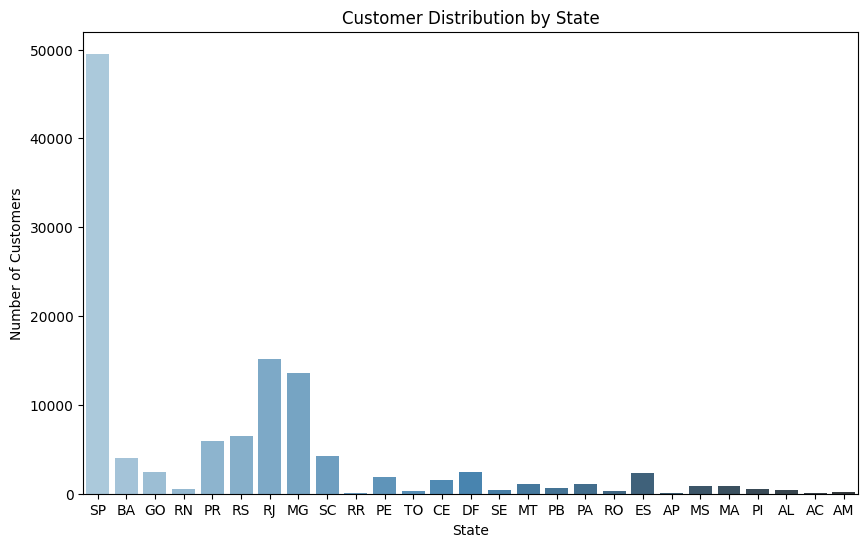

In [42]:
customer_columns = ['order_id', 'customer_id', 'customer_state']

plt.figure(figsize=(10, 6))
sns.countplot(x='customer_state', data=dataset[customer_columns], palette=("Blues_d"))
plt.title('Customer Distribution by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.show()

The result indicates that the customer distribution by state is not even. It suggests that some states have a higher concentration of customers than others. This can be caused by a variety of factors:

1. **Population Size or Density**: Differences in the population size or density of different states can lead to uneven distribution.
2. **Availability or Accessibility**: Variations in the availability or accessibility of the product or service being offered.
3. **Marketing or Sales Efforts**: Differences in marketing or sales efforts in different regions.
4. **Customer Preferences or Needs**: Preferences or needs of customers in different states.

While the exact cause is hard to conclude, we will conduct more analysis in the following sections to gain deeper insights.
